# Example 1 - Profiles extraction

<img src="images/banner3.png" width="100%" />

<font face="Calibri">
<br>
<font size="5"> <b>Profiles creation and data extraction from DSM and orthophotos</b></font>

<br>
<font size="4"> <b> Nicolas Pucino; PhD Student @ Deakin University, Australia </b> <br>
<img style="padding:7px;" src="images/sandpiper_sand_retouched.png" width="170" align="right" /></font>

<font size="3">The first steps in a typical workflow is to create cross-shore transects in all the locations and extract elevation and RGB information along those transects. Sandpiper allows the data extraction from hundreds of rasters at once, in an organised way. <br>

<b>This notebook covers the following concepts:</b>

- Naming conventions and global parameters.
- Setting up the folders.
- Setting up the folders.
</font>


</font>

Import all it is required.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from sandpyper.outils import cross_ref
from sandpyper.profile import extract_from_folder
from sandpyper.space import create_transects

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
pd.read_csv("../doc_data/labels/data_classified.csv")

,point_id,label_k,distance,z,tr_id,raw_date,coordinates,location,survey_date,x,y,geometry,band1,band2,band3,slope,curve
0,67143080l2610320eo00,3,0.2,1.105616,47,20180606,POINT (299873.4167173313 5773731.881880409),leo,2018-06-06,299873.416717,5.773732e+06,POINT (299873.4167173313 5773731.881880409),141.0,142.0,132.0,-0.006003,0.002122
1,67142080l2670630eo00,3,0.3,1.101189,47,20180606,POINT (299873.516093276 5773731.893034852),leo,2018-06-06,299873.516093,5.773732e+06,POINT (299873.516093276 5773731.893034852),148.0,148.0,143.0,-0.003264,0.001769
2,67142080l2600940eo00,3,0.4,1.099089,47,20180606,POINT (299873.6154692209 5773731.904189295),leo,2018-06-06,299873.615469,5.773732e+06,POINT (299873.6154692209 5773731.904189295),140.0,142.0,129.0,-0.002465,0.001138
3,67146080l2650750eo00,6,0.5,1.096259,47,20180606,POINT (299873.7148451657 5773731.915343738),leo,2018-06-06,299873.714845,5.773732e+06,POINT (299873.7148451657 5773731.915343738),162.0,165.0,155.0,-0.000988,0.001301
4,67141080l2600560eo00,3,0.6,1.097113,47,20180606,POINT (299873.8142211105 5773731.92649818),leo,2018-06-06,299873.814221,5.773732e+06,POINT (299873.8142211105 5773731.92649818),152.0,154.0,137.0,0.000136,0.001117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185180,60108091m2528500ar21,9,28.1,1.753726,0,20190516,POINT (731474.0709976825 5705142.514267173),mar,2019-05-16,731474.070998,5.705143e+06,POINT (731474.0709976825 5705142.514267173),198.0,190.0,164.0,-0.007479,0.001382
185181,60103091m2518200ar22,4,28.2,1.748035,0,20190516,POINT (731474.1704055312 5705142.503400728),mar,2019-05-16,731474.170406,5.705143e+06,POINT (731474.1704055312 5705142.503400728),196.0,187.0,161.0,-0.006537,0.000006
185182,60107091m2598900ar23,9,28.3,1.740652,0,20190516,POINT (731474.2698133799 5705142.492534284),mar,2019-05-16,731474.269813,5.705142e+06,POINT (731474.2698133799 5705142.492534284),200.0,192.0,165.0,-0.007468,-0.000615
185183,60102091m2588500ar24,9,28.4,1.733099,0,20190516,POINT (731474.3692212285 5705142.481667838),mar,2019-05-16,731474.369221,5.705142e+06,POINT (731474.3692212285 5705142.481667838),200.0,191.0,164.0,-0.007767,-0.000747


## Global parameters
### Location codes
When your analysis involves a multi-site approach, it is convenient to assign each location a __small code__ to easy the handling of every associated file and its coordinate reference system.

Here are some examples:
* Saint Leonards : __leo__
* Marengo : __mar__

In [3]:
# The location codes used troughout the analysis
loc_codes=["mar","leo"]

### Location search dictionary
Sometimes, we need to automatically obtain the right location code from raster files, either of Digital Surface Models (DSM) or Orthophotos (ORTO), whose filenames contains the original location name (e.g. Saint_Leonards or Warrnambool).

An easy and fast way to do this, is to create a dictionary, where __keys are the location codes__ and the __values are lists of possible full names__ we expect to find in the files.
Here are some examples:

```python
loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }
```
> __NOTE__: always include the location codes in the list of possible names, in case the original raster filenames are already formatted!


In [4]:
# The terms used in the original filenames.
# These will be used to properly format files, extracting location codes and dates.

loc_search_dict = {   'leo': ['St','Leonards','leonards','leo'],
                      'mar': ['Marengo','marengo','mar'] }

### Coordinate Reference Systems dictionary

Working on a wide area, often requires dealing with multiple Coordinate Reference Systems (CRS). Therefore, it is important to assign __each location code with its appropriate CRS__ at the beginning, in order to always take it into account trhoughout the analysis.

We do this with another dictionary, called `crs_dict_string`, where as keys we store the location codes and as values we store another dictionary, in this form `{'init': 'epsg:32754'}` .
Modify the __EPSG code__ to change CRS. Here is an example of the resulting dictionary:

```python
crs_dict_string = {'wbl': {'init': 'epsg:32754'},
                   'apo': {'init': 'epsg:32754'},
                   'prd': {'init': 'epsg:32755'},
                   'dem': {'init': 'epsg:32755'} }
```



> __NOTE:__ to specify the CRS, use the dictionary format supported by Geopandas 0.6.3. Only projected CRS are supported.


In [5]:
# The Coordinate Reference Systems used troughout this example

crs_dict_string= {
                 'mar': {'init': 'epsg:32754'},
                 'leo':{'init': 'epsg:32755'}
                 }

## Transects creation
### Shoreline baseline

Any Shapely line or polyline object can be used as input as a transect. In coastal geomeorphometric studies, transects are usually equally spaced alongshore, and place normal to the shoreline. However, any type of line can be used to extract values from both orthophtos and DSMs.

You can construct transects in 2 ways:
1. **Any GIS**
2. Using the function **create_transects**, starting from a __shoreline baseline__.

If you use your favourite GIS (Qgis preferred), ensure that the output format is __geopackage (.gpkg)__, and:
> **each transect must be in a separate row (geometry)**

If you want to use in-built sandpyper function, see below:

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

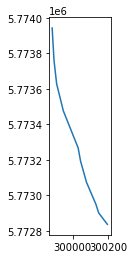

In [6]:
# load and display the shoreline
path_to_shoreline_mar=r'C:\my_packages\doc_data\shorelines\leo_shoreline_short.gpkg' # Marengo shoreline

shoreline=gpd.read_file(path_to_shoreline_mar)
shoreline.plot()

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,tr_id,geometry,location
0,0,"LINESTRING (300166.471 5772833.267, 300206.279...",leo
1,1,"LINESTRING (300154.369 5772849.190, 300194.177...",leo
2,2,"LINESTRING (300142.267 5772865.113, 300182.075...",leo
3,3,"LINESTRING (300130.166 5772881.037, 300169.974...",leo
4,4,"LINESTRING (300119.411 5772904.944, 300165.639...",leo


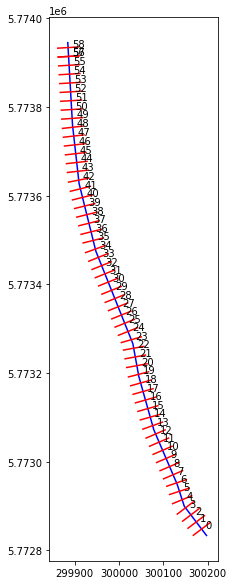

In [7]:
# create and display the transects (in red)

f,ax=plt.subplots(figsize=(10,10))  # Change figsize if you want bigger images
location='leo'  # insert the location code for this transect.

transects=create_transects(shoreline,
                           sampling_step=20, # alongshore spacing
                           tick_length=50, # transects length
                           location=location,crs=crs_dict_string[location],
                           side='both' # 'both':transect is centered at the interesction with the baseline
                          )

# Modify the figure by plotting shoreline, transects and transect IDs.
shoreline.plot(ax=ax,color='b')
transects.plot(ax=ax,color='r')

for x, y, label in zip(transects.geometry.centroid.x, transects.geometry.centroid.y, transects.tr_id):
    ax.annotate(label, xy=(x, y), xytext=(4, 1), textcoords="offset points")

transects.head()

The following cell saves transect to file and name it as:

>__locationCode_whateverYouWant.gpkg__

(example: __leo_transects.gpkg__)

and place it to a folder where you store all the transects for each location.

>__Note:__ If the saving throws an error "PLE_NotSupported in dataset leo_transects.gpkg does not support layer creation option ENCODING", the file should be created and valid anyway. Double-check by opening it in Qgis.

In [8]:
# transects.to_file(filename=r'C:\my_packages\doc_data\transects\leo_transects.gpkg',driver='GPKG')

## Elevation and RGB data extraction

### Define the folders containing the datasets

First, let's define the paths to the folders containing the raster DSMs or ORTOs and the transects.

> __SUPPORTED FORMATS:__
>* Rasters: __geotiffs (.tif, .tiff)__
>* Transects: __geopackages (.gpkg).__
>
>__Transects filenames:__ when creating transects, save them with the location code as filename.

<img src="images/profiles/hill_ortho_profiles_cow.png" width="85%" />

In [9]:
# Set the path to the folders containing the DSMs (dirNameDSM) and the transect files (dirNameTrans)

dirNameDSM=r'C:\my_packages\doc_data\dsm'

dirNameOrtho=r'C:\my_packages\doc_data\ortho'

dirNameTrans=r'C:\my_packages\doc_data\transects'


###  Check cross-reference table and CRS matches

The EPSG codes in the raster and transect columns __must match__.

Please also check the dsm and date columns match transect file and dsm file paths.

In [10]:
check=cross_ref(dirNameDSM,dirNameTrans,print_info=True, loc_search_dict=loc_search_dict,list_loc_codes=loc_codes)
check

DSM from leo = 6

DSM from mar = 9


NUMBER OF DATASETS TO PROCESS: 15


C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


,raw_date,filename_raster,crs_raster,filename_trs,crs_transect
location,,,,,
leo,20180606,C:\my_packages\doc_data\dsm\leo_20180606_dsm_c...,32755,C:\my_packages\doc_data\transects\leo_transect...,epsg:32755
leo,20180713,C:\my_packages\doc_data\dsm\leo_20180713_dsm_c...,32755,C:\my_packages\doc_data\transects\leo_transect...,epsg:32755
leo,20180920,C:\my_packages\doc_data\dsm\leo_20180920_dsm_c...,32755,C:\my_packages\doc_data\transects\leo_transect...,epsg:32755
leo,20190211,C:\my_packages\doc_data\dsm\leo_20190211_dsm_c...,32755,C:\my_packages\doc_data\transects\leo_transect...,epsg:32755
leo,20190328,C:\my_packages\doc_data\dsm\leo_20190328_dsm_c...,32755,C:\my_packages\doc_data\transects\leo_transect...,epsg:32755
leo,20190731,C:\my_packages\doc_data\dsm\leo_20190731_dsm_c...,32755,C:\my_packages\doc_data\transects\leo_transect...,epsg:32755
mar,20180601,C:\my_packages\doc_data\dsm\mar_20180601_dsm_c...,32754,C:\my_packages\doc_data\transects\mar_transect...,epsg:32754
mar,20180621,C:\my_packages\doc_data\dsm\mar_20180621_dsm_c...,32754,C:\my_packages\doc_data\transects\mar_transect...,epsg:32754
mar,20180727,C:\my_packages\doc_data\dsm\mar_20180727_dsm_c...,32754,C:\my_packages\doc_data\transects\mar_transect...,epsg:32754


Nice! We are now ready to extract data from DSMs or ORTOs with the provided transect files.

### Extraction of profiles from folder

This is the cell where the automatic extraction gets processed.
The only parameter to set is the __sampling step__ variable, which indicates the __cross-shore sampling distance (m)__ that we want to use along our transects. Beware, although you could use a very small sampling distance (UAV datasets tend to be between few to 10 cm pixel size), file dimension will increase significantly!.

__Dealing with NaNs__

>NaNs might come from two different cases:
>1. extraction of points generated on transects falling __outside__ of the underlying raster extent
>2. points sampled from transect __inside__ the raster extent but containing NoData cells.
>
>Conveniently, the extraction profile function makes sure that if points fall outside the raster extent (case 1), those >elevations are assigned a default nan value, in the NumPy np.nan form.
>In case 2, however, the values extracted depends on the definition of NaNs of the source raster format.

In [11]:
%%time

## Parameters to specify

transect_folder=dirNameTrans
sampling_step=0.1


gdf_rgb=extract_from_folder(dataset_folder=dirNameOrtho,
                        transect_folder=transect_folder,
                        mode="ortho",sampling_step=sampling_step,
                        list_loc_codes=loc_codes,
                        add_xy=True)

gdf=extract_from_folder(dataset_folder=dirNameDSM,
                        transect_folder=transect_folder,
                        mode="dsm",sampling_step=sampling_step,
                        list_loc_codes=loc_codes,
                        add_xy=True)


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:295740
Time for processing=274.16132616996765 seconds
First 10 rows are printed below
Number of points outside the raster extents: 329697
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 0
The extraction assigns NaN.


  0%|          | 0/15 [00:00<?, ?it/s]

C:\conda3\envs\sandpyper_env\lib\site-packages\geopandas\geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Extraction succesfull
Number of points extracted:295740
Time for processing=265.16719675064087 seconds
First 10 rows are printed below
Number of points outside the raster extents: 109897
The extraction assigns NaN.
Number of points in NoData areas within the raster extents: 486
The extraction assigns NaN.
Wall time: 8min 59s


### GOOD!

save the Geodataframes (gdf and gdf_rgb) as a CSV file and head to the __SANDPYPER Labeling sand notebook__.

In [13]:
# Saving the files

#gdf.to_csv(r"C:\my_packages\doc_data\profiles\elevation.csv",index=False)
#gdf_rgb.to_csv(r"C:\my_packages\doc_data\profiles\rgb.csv",index=False)

___